## Exploratory Data Analysis

### Imports and definitions

In [116]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import albumentations
import albumentations.pytorch
import shap
import importlib
import mlflow
import preprocessing.crop_brain_region
import utils.train_eval
import utils.load_images
import utils.metrics
import utils.plots
import utils.mlflow

#### Random seeds for reproducibility

In [76]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
sklearn.random.seed(0)

#### Set the device to run the models, GPU if it is available

In [77]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")

#### Constants

In [89]:
IMAGE_SIZE = (224, 224)
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

mlflow.set_tracking_uri("sqlite:///mlflow.db")

#### Download the dataset

To run this, it's needed to have kaggle.json from a kaggle key in ~/.kaggle folder

Alternatively, skip this part and manually download the dataset https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection in ./data folder

In [79]:
import kaggle

os.makedirs("data", exist_ok=True)

kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    "volodymyrpivoshenko/brain-mri-scan-images-tumor-detection", path="data", unzip=True
)

kaggle.api.dataset_download_files(
    "navoneel/brain-mri-images-for-brain-tumor-detection", path="data", unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


### Loading images

In [80]:
images, labels = utils.load_images.load_images()

#### Visualizing images of each class

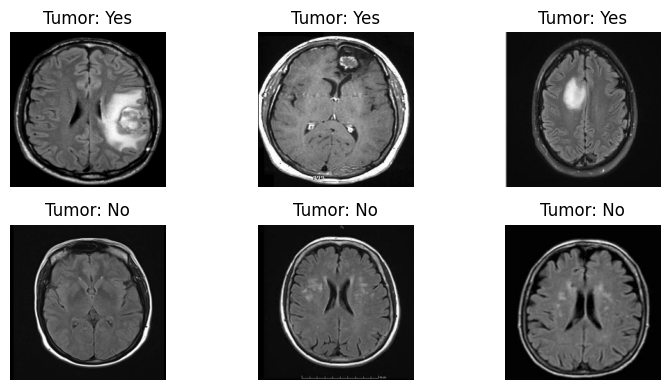

In [81]:
plt.figure(figsize=(8, 4))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[labels == 1][i + 10])
    plt.title("Tumor: Yes")
    plt.axis("off")

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.imshow(images[labels == 0][i + 10])
    plt.title("Tumor: No")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Visualizing class distribution

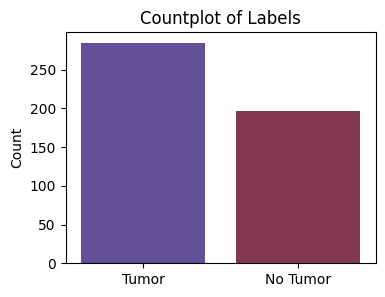

In [82]:
labels_nominal = np.where(labels == 0, "No Tumor", "Tumor")
plt.figure(figsize=(4, 3))
sns.countplot(x=labels_nominal, hue=labels_nominal, palette="twilight")
plt.title("Countplot of Labels")
plt.ylabel("Count")
plt.show()

### Data pre-processing

Using a custom transformation to crop the brain region, it is defined in [this python file](preprocessing/crop_brain_region.py) and it is possible to check its visual results in [this notebook](preprocessing/crop_brain_region_visualization.ipynb)

In [83]:
test_transform = albumentations.Compose(
    [
        preprocessing.crop_brain_region.CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.Normalize(mean=MEAN, std=STD),
        albumentations.pytorch.ToTensorV2(),
    ]
)

train_transform = albumentations.Compose(
    [
        preprocessing.crop_brain_region.CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.5
        ),
        albumentations.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5
        ),
        albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albumentations.GaussNoise(var_limit=(10, 50), p=0.5),
        albumentations.Normalize(mean=MEAN, std=STD),
        albumentations.pytorch.ToTensorV2(),
    ]
)

#### Data splitting

In [84]:
train_images, remaining_images, train_labels, remaining_labels = (
    sklearn.model_selection.train_test_split(
        images, labels, test_size=0.2, random_state=0
    )
)

val_images, test_images, val_labels, test_labels = (
    sklearn.model_selection.train_test_split(
        remaining_images, remaining_labels, test_size=0.5, random_state=0
    )
)

print("Train dataset size:", len(train_images))
print("Validation dataset size:", len(val_images))
print("Test dataset size:", len(test_images))

Train dataset size: 384
Validation dataset size: 48
Test dataset size: 48


#### Defining the dataset

In [85]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

In [86]:
train_dataset = BrainTumorDataset(train_images, train_labels, transform=train_transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=test_transform)
test_dataset = BrainTumorDataset(test_images, test_labels, transform=test_transform)

batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [87]:
loss = nn.BCELoss()

### Baseline CNN

Baseline CNN model, for exploratory data analysis

In [40]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 26 * 26, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
model.to(device)
optim = torch.optim.Adam(model.parameters())

print("{:,}".format(sum(p.numel() for p in model.parameters())))

11,169,089


#### Training the baseline model

2024/07/15 23:32:58 INFO mlflow.tracking.fluent: Experiment with name 'Brain Tumor Detection - Model Training and Evaluation' does not exist. Creating a new experiment.
2024/07/15 23:32:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/15 23:32:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
100%|██████████| 48/48 [00:10<00:00,  4.53it/s]


Epoch 3/5. Train Loss: 0.2074, Validation Loss: 0.1816, Validation Accuracy: 0.9167


100%|██████████| 48/48 [00:09<00:00,  4.88it/s]


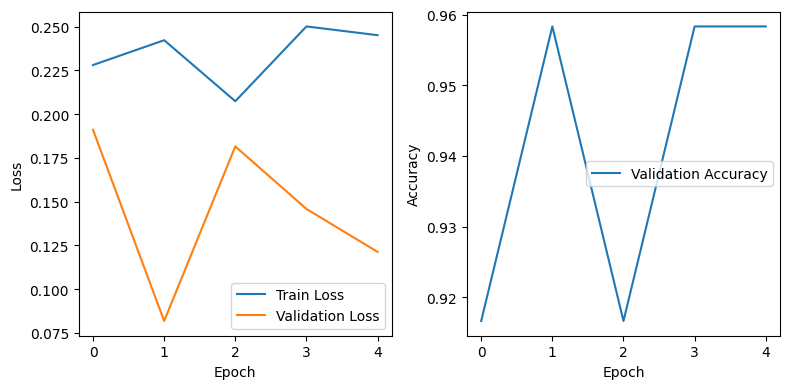

In [117]:
importlib.reload(utils.train_eval)
importlib.reload(utils.plots)
importlib.reload(utils.mlflow)

mlflow.set_experiment("Brain Tumor Detection - Model Training and Evaluation")

time_now = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")

mlflow.start_run(run_name=time_now, log_system_metrics=True)

run_id = mlflow.active_run().info.run_id

num_epochs = 5

mlflow.set_tag("model", "baseline_cnn")

mlflow.log_param("Number of Epochs", num_epochs)
mlflow.log_param("Batch Size", batch_size)

mlflow.log_param("Train Dataset Size", len(train_loader.dataset))
mlflow.log_param("Validation Dataset Size", len(val_loader.dataset))
mlflow.log_param("Test Dataset Size", len(test_loader.dataset))

mlflow.log_param("Model Name", "Baseline CNN")
mlflow.log_param(
    "Model Trainable Parameters",
    "{:,}".format(sum(p.numel() for p in model.parameters())),
)

mlflow.log_param("Model Architecture", model)

mlflow.log_param("Optimizer", "Adam")
mlflow.log_param(
    "Adam parameters",
    {
        "lr": optim.param_groups[0]["lr"],
        "betas": optim.param_groups[0]["betas"],
        "eps": optim.param_groups[0]["eps"],
        "weight_decay": optim.param_groups[0]["weight_decay"],
        "amsgrad": optim.param_groups[0]["amsgrad"],
    },
)

mlflow.log_param("Loss Function", "BCELoss")

mlflow.log_param("Train Transforms", train_transform)
mlflow.log_param("Test Transforms", test_transform)

os.makedirs("checkpoints", exist_ok=True)

train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = utils.train_eval.train_epoch(model, train_loader, loss, optim, device)
    val_loss, val_acc, _ = utils.train_eval.eval_model(model, val_loader, loss, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join("checkpoints", "baseline_cnn.pth"))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    mlflow.log_metric("Train Loss", train_loss, epoch)
    mlflow.log_metric("Validation Loss", val_loss, epoch)
    mlflow.log_metric("Validation Accuracy", val_acc, epoch)

    if epoch % 3 == 2:
        print(
            f"Epoch {epoch + 1}/{num_epochs}. Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}"
        )

mlflow.log_metric("Best Validation Loss", best_val_loss)
utils.plots.plot_train_and_val_losses(train_losses, val_losses, val_accs)

model.load_state_dict(torch.load(os.path.join("checkpoints", "baseline_cnn.pth")))
mlflow.pytorch.log_model(model, "models")

#### Evaluating baseline CNN

           Validation  Test
Accuracy     0.958333   1.0
Precision    1.000000   1.0
Recall       0.935484   1.0
F1-Score     0.966667   1.0


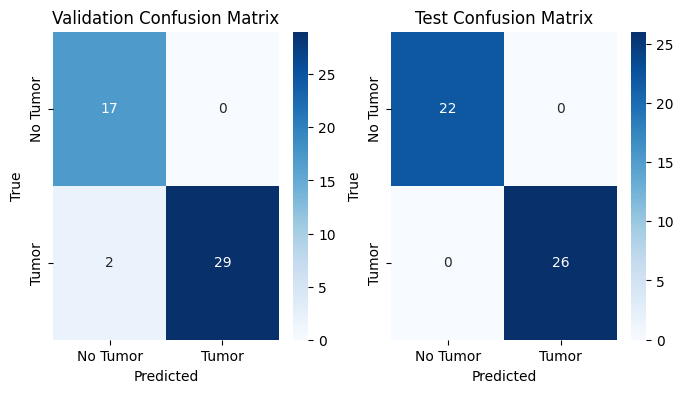

2024/07/15 23:33:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/15 23:33:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [118]:
_, _, val_confusion_matrix = utils.train_eval.eval_model(
    model, val_loader, loss, device
)
_, _, test_confusion_matrix = utils.train_eval.eval_model(
    model, test_loader, loss, device
)

val_metrics = utils.metrics.get_metrics_from_confusion_matrix(val_confusion_matrix)
test_metrics = utils.metrics.get_metrics_from_confusion_matrix(test_confusion_matrix)

utils.mlflow.log_evaluation_metrics("Validation", val_metrics, val_confusion_matrix)
utils.mlflow.log_evaluation_metrics("Test", test_metrics, test_confusion_matrix)

utils.plots.plot_evaluation_result(
    val_metrics, test_metrics, val_confusion_matrix, test_confusion_matrix
)

mlflow.end_run()

### Shapley Values

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


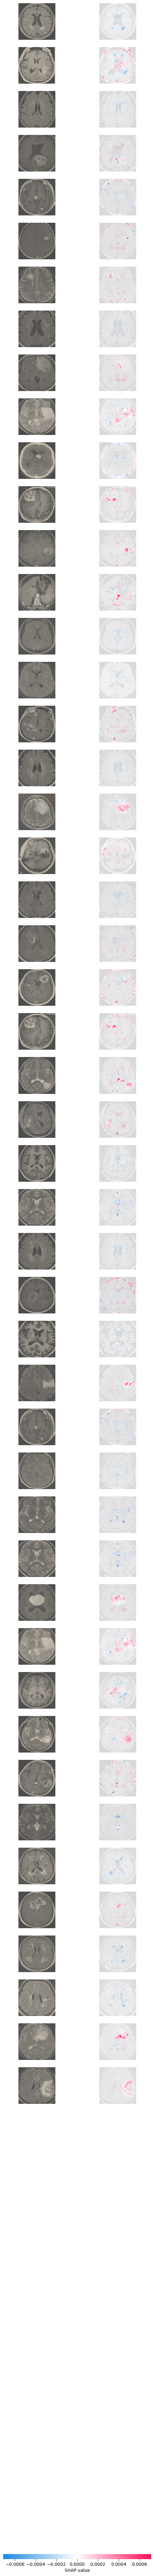

In [45]:
model.to("cpu")
model.eval()
test_loader_one_batch = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0
)

# Get a batch of data for SHAP explainer
inputs, targets = next(iter(test_loader_one_batch))
inputs, targets = inputs.to("cpu"), targets.to("cpu")

# Initialize SHAP DeepExplainer with the model and a sample of the test data
explainer = shap.DeepExplainer(model, inputs)

# Change from NCHW to NHWC
inputs_numpy = inputs.permute(0, 2, 3, 1).numpy()

inputs_numpy = inputs_numpy * MEAN + STD

# Compute SHAP values for the test data
shap_values = explainer.shap_values(inputs)

shap_values_numpy = np.array(shap_values)
shap_values_numpy = shap_values_numpy.squeeze().transpose(0, 2, 3, 1)

# Undo the standardization
mean = np.array(MEAN).reshape(1, 1, 1, 3)
std = np.array(STD).reshape(1, 1, 1, 3)
inputs_numpy = inputs_numpy * std + mean

# Plot the SHAP values for the first image
shap.image_plot(shap_values_numpy, inputs_numpy)

### ResNet-18

In [46]:
resnet18 = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
resnet18.fc = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())

for name, param in resnet18.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


resnet18.to(device)
print()

In [47]:
import utils.train_eval

importlib.reload(utils.train_eval)

num_epochs = 90

os.makedirs("checkpoints", exist_ok=True)

train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")

optim_resnet = torch.optim.Adam(resnet18.parameters())

for epoch in range(num_epochs):
    train_loss = utils.train_eval.train_epoch(
        resnet18, train_loader, loss, optim_resnet, device
    )
    val_loss, val_acc, _ = utils.train_eval.eval_model(
        resnet18, val_loader, loss, device
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(resnet18.state_dict(), os.path.join("checkpoints", "resnet_18.pth"))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 3 == 2:
        print(
            f"Epoch {epoch + 1}/{num_epochs}. Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}"
        )

    if epoch == 20:
        for name, param in resnet18.named_parameters():
            if "fc" not in name and "layer4" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        optim_resnet_t2 = torch.optim.Adam(resnet18.parameters(), lr=1e-4)

    if epoch == 60:
        for name, param in resnet18.named_parameters():
            if "fc" not in name and "layer4" not in name and "layer3" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

100%|██████████| 48/48 [00:13<00:00,  3.59it/s]


Epoch 3/90. Train Loss: 0.5816, Validation Loss: 0.5260, Validation Accuracy: 0.8125


100%|██████████| 48/48 [00:11<00:00,  4.26it/s]


Epoch 6/90. Train Loss: 0.5356, Validation Loss: 0.3939, Validation Accuracy: 0.8750


100%|██████████| 48/48 [00:10<00:00,  4.55it/s]


Epoch 9/90. Train Loss: 0.4795, Validation Loss: 0.3119, Validation Accuracy: 0.8958


100%|██████████| 48/48 [00:12<00:00,  3.72it/s]


Epoch 12/90. Train Loss: 0.4617, Validation Loss: 0.4236, Validation Accuracy: 0.8125


100%|██████████| 48/48 [00:10<00:00,  4.63it/s]


Epoch 15/90. Train Loss: 0.4274, Validation Loss: 0.3169, Validation Accuracy: 0.8542


100%|██████████| 48/48 [00:09<00:00,  4.95it/s]


Epoch 18/90. Train Loss: 0.4379, Validation Loss: 0.5058, Validation Accuracy: 0.7500


100%|██████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch 21/90. Train Loss: 0.4616, Validation Loss: 0.4204, Validation Accuracy: 0.7917


100%|██████████| 48/48 [00:11<00:00,  4.08it/s]


Epoch 24/90. Train Loss: 0.3369, Validation Loss: 0.3612, Validation Accuracy: 0.8333


100%|██████████| 48/48 [00:11<00:00,  4.25it/s]


Epoch 27/90. Train Loss: 0.2612, Validation Loss: 0.2189, Validation Accuracy: 0.8750


100%|██████████| 48/48 [00:11<00:00,  4.34it/s]


Epoch 30/90. Train Loss: 0.1821, Validation Loss: 0.2846, Validation Accuracy: 0.8125


100%|██████████| 48/48 [00:11<00:00,  4.35it/s]


Epoch 33/90. Train Loss: 0.1329, Validation Loss: 0.3240, Validation Accuracy: 0.9167


100%|██████████| 48/48 [00:11<00:00,  4.22it/s]


Epoch 36/90. Train Loss: 0.1842, Validation Loss: 0.1835, Validation Accuracy: 0.9167


100%|██████████| 48/48 [00:10<00:00,  4.40it/s]


Epoch 39/90. Train Loss: 0.1852, Validation Loss: 0.2600, Validation Accuracy: 0.9167


100%|██████████| 48/48 [00:11<00:00,  4.05it/s]


Epoch 42/90. Train Loss: 0.1633, Validation Loss: 0.0749, Validation Accuracy: 0.9583


100%|██████████| 48/48 [00:11<00:00,  4.18it/s]


Epoch 45/90. Train Loss: 0.2006, Validation Loss: 0.3618, Validation Accuracy: 0.8542


100%|██████████| 48/48 [00:11<00:00,  4.16it/s]


Epoch 48/90. Train Loss: 0.1354, Validation Loss: 0.2813, Validation Accuracy: 0.9167


100%|██████████| 48/48 [00:11<00:00,  4.19it/s]


Epoch 51/90. Train Loss: 0.0924, Validation Loss: 0.2919, Validation Accuracy: 0.8958


100%|██████████| 48/48 [00:11<00:00,  4.27it/s]


Epoch 54/90. Train Loss: 0.1931, Validation Loss: 0.6404, Validation Accuracy: 0.8333


100%|██████████| 48/48 [00:11<00:00,  4.12it/s]


Epoch 57/90. Train Loss: 0.0979, Validation Loss: 0.4074, Validation Accuracy: 0.8958


100%|██████████| 48/48 [00:11<00:00,  4.24it/s]


Epoch 60/90. Train Loss: 0.1113, Validation Loss: 0.0834, Validation Accuracy: 0.9583


100%|██████████| 48/48 [00:12<00:00,  3.75it/s]


Epoch 63/90. Train Loss: 0.3198, Validation Loss: 0.4419, Validation Accuracy: 0.8333


100%|██████████| 48/48 [00:13<00:00,  3.57it/s]


Epoch 66/90. Train Loss: 0.2220, Validation Loss: 0.5503, Validation Accuracy: 0.7292


100%|██████████| 48/48 [00:13<00:00,  3.55it/s]


Epoch 69/90. Train Loss: 0.1243, Validation Loss: 0.6961, Validation Accuracy: 0.8333


100%|██████████| 48/48 [00:12<00:00,  3.71it/s]


Epoch 72/90. Train Loss: 0.2487, Validation Loss: 0.5430, Validation Accuracy: 0.8750


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]


Epoch 75/90. Train Loss: 0.1221, Validation Loss: 0.3971, Validation Accuracy: 0.8750


100%|██████████| 48/48 [00:10<00:00,  4.44it/s]


Epoch 78/90. Train Loss: 0.5011, Validation Loss: 0.6237, Validation Accuracy: 0.8750


100%|██████████| 48/48 [00:10<00:00,  4.62it/s]


Epoch 81/90. Train Loss: 0.1783, Validation Loss: 0.8598, Validation Accuracy: 0.8542


100%|██████████| 48/48 [00:10<00:00,  4.52it/s]


Epoch 84/90. Train Loss: 0.1003, Validation Loss: 0.3962, Validation Accuracy: 0.8750


100%|██████████| 48/48 [17:53<00:00, 22.36s/it] 


Epoch 87/90. Train Loss: 0.0896, Validation Loss: 0.4035, Validation Accuracy: 0.8750


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


Epoch 90/90. Train Loss: 0.0783, Validation Loss: 0.4156, Validation Accuracy: 0.8750


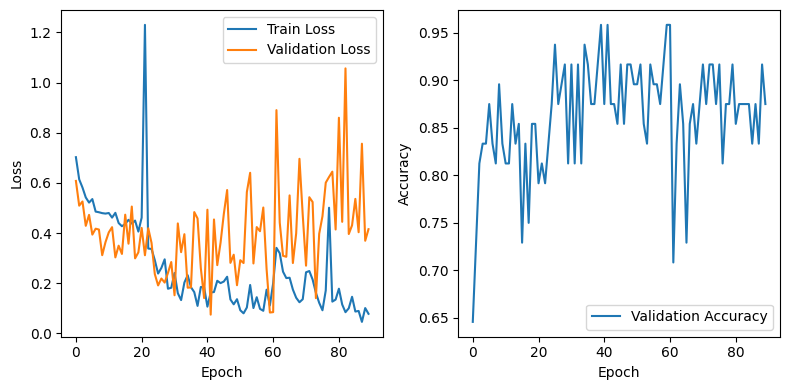

In [48]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
resnet18_model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
resnet18_model.fc = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
resnet18_model.load_state_dict(torch.load(os.path.join("checkpoints", "resnet_18.pth")))
resnet18_model.to(device)
print()

           Validation      Test
Accuracy     0.958333  0.958333
Precision    1.000000  0.928571
Recall       0.935484  1.000000
F1-Score     0.966667  0.962963


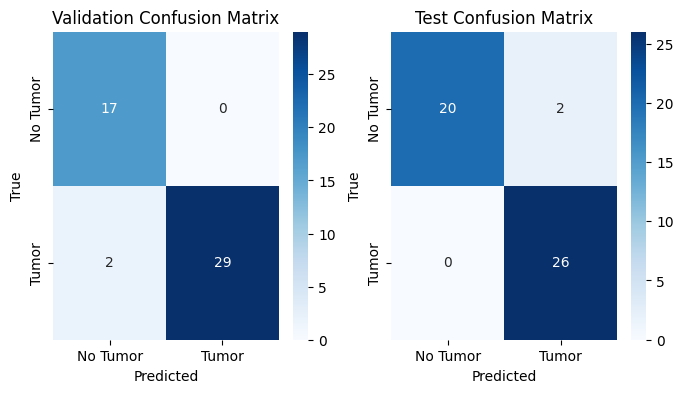

In [50]:
_, _, val_confusion_matrix = utils.train_eval.eval_model(
    resnet18_model, val_loader, loss, device
)
_, _, test_confusion_matrix = utils.train_eval.eval_model(
    resnet18_model, test_loader, loss, device
)

val_metrics = utils.metrics.get_metrics_from_confusion_matrix(val_confusion_matrix)
test_metrics = utils.metrics.get_metrics_from_confusion_matrix(test_confusion_matrix)

df = pd.DataFrame(
    {
        "Validation": [
            val_metrics["accuracy"],
            val_metrics["precision"],
            val_metrics["recall"],
            val_metrics["f1_score"],
        ],
        "Test": [
            test_metrics["accuracy"],
            test_metrics["precision"],
            test_metrics["recall"],
            test_metrics["f1_score"],
        ],
    },
    index=["Accuracy", "Precision", "Recall", "F1-Score"],
)
print(df)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.heatmap(
    val_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Tumor", "Tumor"],
    yticklabels=["No Tumor", "Tumor"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(
    test_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Tumor", "Tumor"],
    yticklabels=["No Tumor", "Tumor"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")

plt.show()

In [69]:
def remove_inplace_relu(module):
    if isinstance(module, nn.ReLU):
        module.inplace = False


resnet18_model.apply(remove_inplace_relu)


def replace_inplace_addition(module, input, output):
    return output.clone() + input


for layer in resnet18_model.modules():
    if isinstance(layer, torchvision.models.resnet.BasicBlock):
        layer.register_forward_hook(replace_inplace_addition)

print()

In [70]:
resnet18_model.to("cpu")
resnet18_model.eval()
test_loader_one_batch = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0
)

# Get a batch of data for SHAP explainer
inputs, targets = next(iter(test_loader_one_batch))
inputs, targets = inputs.to("cpu"), targets.to("cpu")

# Initialize SHAP DeepExplainer with the model and a sample of the test data
explainer = shap.DeepExplainer(resnet18_model, inputs)

# Change from NCHW to NHWC
inputs_numpy = inputs.permute(0, 2, 3, 1).numpy()

inputs_numpy = inputs_numpy * MEAN + STD

# Compute SHAP values for the test data
shap_values = explainer.shap_values(inputs)

shap_values_numpy = np.array(shap_values)
shap_values_numpy = shap_values_numpy.squeeze().transpose(0, 2, 3, 1)

# Undo the standardization
mean = np.array(MEAN).reshape(1, 1, 1, 3)
std = np.array(STD).reshape(1, 1, 1, 3)
inputs_numpy = inputs_numpy * std + mean

# Plot the SHAP values for the first image
shap.image_plot(shap_values_numpy, inputs_numpy)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'tuple'

In [73]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow/mlflow.db")
mlflow.set_experiment("test")

<Experiment: artifact_location='/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/mlruns/1', creation_time=1721062819858, experiment_id='1', last_update_time=1721062819858, lifecycle_stage='active', name='test', tags={}>

In [74]:
with mlflow.start_run():
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_workers", num_workers)
    mlflow.log_param("learning_rate", optim.param_groups[0]["lr"])
    mlflow.log_param("weight_decay", optim.param_groups[0]["weight_decay"])
    mlflow.log_param("model_name", "baseline_cnn")
    mlflow.log_metric("best_val_loss", best_val_loss)
    mlflow.log_metrics(val_metrics)
    mlflow.log_metrics(test_metrics)
    mlflow.log_artifact(os.path.join("checkpoints", "baseline_cnn.pth"))
    mlflow.end_run()